# Introduction to Machine Learning With NBA Data
#### A project designed for learning machine learning for the purposes of NBA data journalism. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

### Question 1:
Cluster NBA players by playing style using nba_api data (per 100 possessions data)

In [2]:
from nba_api.stats.endpoints import LeagueDashPlayerStats
import time

In [3]:
def fetch_player_base_stats(season):
    # Fetch player statistics for the specified season
    response = LeagueDashPlayerStats(
        season=season,
        per_mode_detailed='Per100Possessions',
        season_type_all_star='Regular Season',
        measure_type_detailed_defense='Base',
        plus_minus='N',
        rank='N',
        pace_adjust='N'
    )

    # Convert the response to a DataFrame
    player_base_stats_df = response.get_data_frames()[0]
    player_base_stats_df['SEASON'] = season
    return player_base_stats_df

df_2026 = fetch_player_base_stats('2025-26')
df_2026.columns


Index(['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK',
       'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK', 'TEAM_COUNT',
       'SEASON'],
      dtype='object')

In [4]:
# fetch advanced stats
def fetch_player_advanced_stats(season):
    # Fetch player advanced statistics for the specified season
    response = LeagueDashPlayerStats(
        season=season,
        per_mode_detailed='Per100Possessions',
        season_type_all_star='Regular Season',
        measure_type_detailed_defense='Advanced',
        plus_minus='N',
        rank='N',
        pace_adjust='N'
    )

    # Convert the response to a DataFrame
    player_advanced_stats_df = response.get_data_frames()[0]
    player_advanced_stats_df['SEASON'] = season
    return player_advanced_stats_df

df_2026_advanced = fetch_player_advanced_stats('2025-26')
df_2026_advanced.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RATING', 'OFF_RATING',
       'sp_work_OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
       'sp_work_DEF_RATING', 'E_NET_RATING', 'NET_RATING',
       'sp_work_NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT',
       'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'E_TOV_PCT', 'EFG_PCT', 'TS_PCT',
       'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'sp_work_PACE',
       'PIE', 'POSS', 'FGM', 'FGA', 'FGM_PG', 'FGA_PG', 'FG_PCT', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'E_OFF_RATING_RANK',
       'OFF_RATING_RANK', 'sp_work_OFF_RATING_RANK', 'E_DEF_RATING_RANK',
       'DEF_RATING_RANK', 'sp_work_DEF_RATING_RANK', 'E_NET_RATING_RANK',
       'NET_RATING_RANK', 'sp_work_NET_RATING_RANK', 'AST_PCT_RANK',
       'AST_TO_RANK', 'AST_RATIO_RANK', 'OREB_PCT_RANK', 'DREB_PCT_RANK',
       'REB_PCT_RANK', 'TM_TOV_PCT_RANK', 'E_TOV_PCT_

Pull multiple seasons to loop through and assign to an array of dataframes called dfs

In [5]:
# fetch real minutes played
def fetch_player_minutes(season):
    response = LeagueDashPlayerStats(
        season=season,
        per_mode_detailed="PerGame",
        season_type_all_star="Regular Season",
        measure_type_detailed_defense="Base"
    )
    df = response.get_data_frames()[0]
    df["SEASON"] = season

    return df[["PLAYER_ID", "SEASON", "MIN", "GP"]]

minutes_df = fetch_player_minutes("2024-25")
minutes_df = minutes_df.rename(columns={"MIN": "MPG"})
minutes_df["SEASON_MIN"] = minutes_df["MPG"] * minutes_df["GP"]

In [6]:
BASE_FEATURES = [
    "PLAYER_ID",
    "PLAYER_NAME",
    "SEASON",
    "PTS",
    "FGA",
    "FG3A",
    "FTA",
    "AST",
    "REB",
    "OREB",
    "DREB",
    "STL",
    "BLK",
    "TOV",
    "PF",
    "PFD",
    "PLUS_MINUS"
]

ADV_FEATURES = [
    "PLAYER_ID",
    "SEASON",
    "TS_PCT",
    "USG_PCT",
    "AST_PCT",
    "REB_PCT",
    "OFF_RATING",
    "DEF_RATING"
]

In [8]:
seasons = ["2023-24", "2024-25", "2025-26"]
# fetch minutes for all seasons
dfs_minutes = []

for season in seasons:
    df_min = fetch_player_minutes(season)
    dfs_minutes.append(df_min)
    time.sleep(2)

minutes_raw = pd.concat(dfs_minutes, ignore_index=True)

minutes_raw = minutes_raw.rename(columns={"MIN": "MPG"})
minutes_raw["SEASON_MIN"] = minutes_raw["MPG"] * minutes_raw["GP"]


In [10]:
# define array of seasons
seasons = ['2023-24', '2024-25', '2025-26']

dfs = []
for season in seasons:
    df = fetch_player_base_stats(season)
    dfs.append(df)
    time.sleep(2)  # Wait for 2 seconds before making the next API call

# concatenate all DataFrames into one
players_raw_base = pd.concat(dfs, ignore_index=True)

# fetch advanced stats for all seasons
dfs_advanced = []
for season in seasons:
    df_advanced = fetch_player_advanced_stats(season)
    dfs_advanced.append(df_advanced)
    time.sleep(4)  # Wait for 2 seconds before making the next API call

# concatenate all advanced DataFrames into one
players_raw_advanced = pd.concat(dfs_advanced, ignore_index=True)

players_raw_base = players_raw_base[BASE_FEATURES]
players_raw_advanced = players_raw_advanced[ADV_FEATURES]


In [11]:
# merge the two DataFrames on PLAYER_ID and SEASON
players_merged = pd.merge(players_raw_base, players_raw_advanced, on=["PLAYER_ID", "SEASON"], how="inner")
players_merged.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'SEASON', 'PTS', 'FGA', 'FG3A', 'FTA',
       'AST', 'REB', 'OREB', 'DREB', 'STL', 'BLK', 'TOV', 'PF', 'PFD',
       'PLUS_MINUS', 'TS_PCT', 'USG_PCT', 'AST_PCT', 'REB_PCT', 'OFF_RATING',
       'DEF_RATING'],
      dtype='object')

In [12]:
# merge minutes played data
players_merged = pd.merge(
    players_merged,
    minutes_raw,
    on=["PLAYER_ID", "SEASON"],
    how="left",
    validate="one_to_one"
)


In [13]:
# Compute advanced metrics from basic metrics
players_merged['3PAr'] = players_merged['FG3A'] / players_merged['FGA']
players_merged['FTr'] = players_merged['FTA'] / players_merged['FGA']


In [14]:
players_merged = players_merged.dropna()
players_merged = players_merged.reset_index(drop=True)
players_merged.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'SEASON', 'PTS', 'FGA', 'FG3A', 'FTA',
       'AST', 'REB', 'OREB', 'DREB', 'STL', 'BLK', 'TOV', 'PF', 'PFD',
       'PLUS_MINUS', 'TS_PCT', 'USG_PCT', 'AST_PCT', 'REB_PCT', 'OFF_RATING',
       'DEF_RATING', 'MPG', 'GP', 'SEASON_MIN', '3PAr', 'FTr'],
      dtype='object')

In [15]:
# inspect the merged DataFrame
players_merged.shape
players_merged.duplicated(["PLAYER_ID", "SEASON"]).sum()
players_merged.isna().sum().sort_values(ascending=False).head()



PLAYER_ID      0
PLAYER_NAME    0
SEASON         0
PTS            0
FGA            0
dtype: int64

In [19]:
# set minimum minutes played threshold
MIN_SEASON_MIN = 300  # ~8 MPG over 40 games, or 15 MPG over 20 games

players_model = players_merged[
    players_merged["SEASON_MIN"] >= MIN_SEASON_MIN
].reset_index(drop=True)

In [20]:
CLUSTER_FEATURES = [
    # Scoring & usage
    "PTS",        # per 100
    "TS_PCT",
    "USG_PCT",
    "3PAr",
    "FTr",

    # Playmaking
    "AST_PCT",
    "TOV",

    # Rebounding
    "REB_PCT",

    # Defense (activity)
    "STL",
    "BLK",

    # Fouls / physicality
    "PF",
    "PFD",

    # time played
    "SEASON_MIN"
]


X = players_model[CLUSTER_FEATURES].values

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply k-means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
players_model['CLUSTER'] = kmeans.fit_predict(X_scaled)

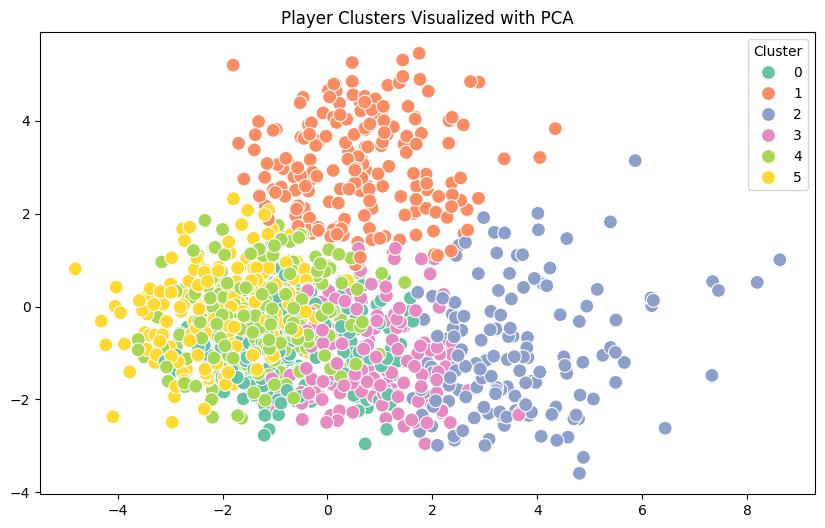

In [21]:
# visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=players_model['CLUSTER'],
    palette='Set2',
    s=100,
    ax=ax
)

ax.set_title('Player Clusters Visualized with PCA')
ax.legend(title='Cluster')

fig.savefig('player_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# summarize the clusters
cluster_summary = (
    players_model
    .groupby('CLUSTER')[CLUSTER_FEATURES]
    .mean()
    .round(2)
    .reset_index()
)
cluster_summary

,CLUSTER,PTS,TS_PCT,USG_PCT,3PAr,FTr,AST_PCT,TOV,REB_PCT,STL,BLK,PF,PFD,SEASON_MIN
0,0,21.34,0.58,0.18,0.51,0.18,0.13,2.10,0.07,1.41,0.76,3.23,2.77,1996.94
1,1,19.21,0.62,0.16,0.13,0.35,0.10,2.47,0.15,1.34,2.13,5.22,4.17,952.12
2,2,33.53,0.60,0.28,0.33,0.35,0.25,3.87,0.09,1.59,0.91,3.27,6.66,1728.56
3,3,22.53,0.54,0.21,0.39,0.24,0.24,3.67,0.07,1.84,0.64,3.92,3.99,1012.83
4,4,19.72,0.58,0.17,0.55,0.20,0.11,1.98,0.07,1.26,0.69,3.78,2.74,708.63
5,5,14.95,0.54,0.14,0.51,0.17,0.12,1.93,0.08,2.21,0.88,4.15,2.15,792.82


In [23]:
# save the clustered summary to a CSV file
cluster_summary.to_csv('cluster_summary.csv', index=False)

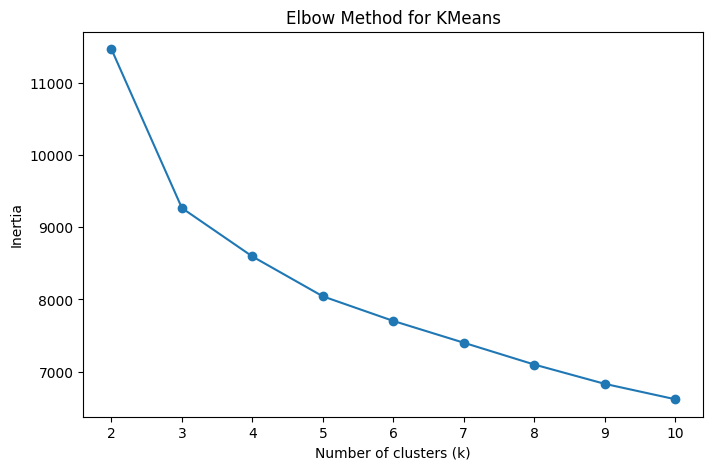

In [26]:
# test the limits of kmeans clustering with the elbow method

inertias = []
K_RANGE = range(2, 11)

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_RANGE, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.savefig('kmeans_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()


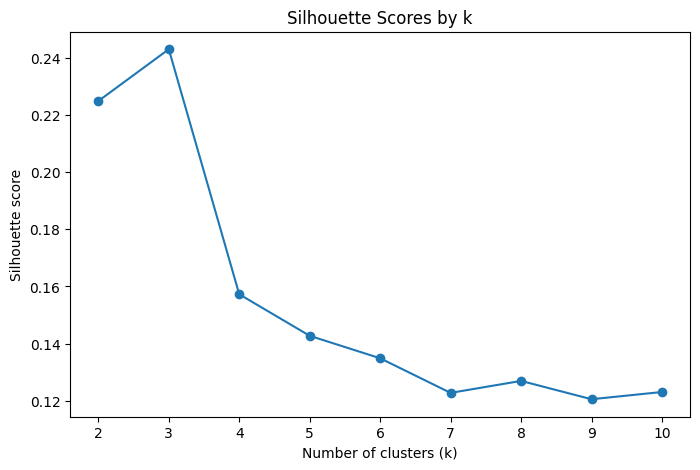

In [27]:
# evaluate clusters with silhouette scores
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores by k")
plt.savefig('silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()


In [28]:
cluster_summary

,CLUSTER,PTS,TS_PCT,USG_PCT,3PAr,FTr,AST_PCT,TOV,REB_PCT,STL,BLK,PF,PFD,SEASON_MIN
0,0,21.34,0.58,0.18,0.51,0.18,0.13,2.10,0.07,1.41,0.76,3.23,2.77,1996.94
1,1,19.21,0.62,0.16,0.13,0.35,0.10,2.47,0.15,1.34,2.13,5.22,4.17,952.12
2,2,33.53,0.60,0.28,0.33,0.35,0.25,3.87,0.09,1.59,0.91,3.27,6.66,1728.56
3,3,22.53,0.54,0.21,0.39,0.24,0.24,3.67,0.07,1.84,0.64,3.92,3.99,1012.83
4,4,19.72,0.58,0.17,0.55,0.20,0.11,1.98,0.07,1.26,0.69,3.78,2.74,708.63
5,5,14.95,0.54,0.14,0.51,0.17,0.12,1.93,0.08,2.21,0.88,4.15,2.15,792.82


The clusters point to different player archetypes, with 0 being most likely centers who primarily work in the paint, 3 being high usage on ball creators like Luka or Harden or Shai, 1 being role players who spot up and play defense, so three-and-D types, and 2 and 4 being lower usage secondary scorers.

In [31]:
# rename clusters based on summary
cluster_names = {
    0: 'Off-ball Scorers', # movement shooters, scoring wings, floor spacers who attack closeouts (Donte DiVincenzo, Desmond Bane, Buddy Hield)
    1: 'Paint Anchors', # non-shooting bigs, rim protectors and attackers (Giannis, Gobert, Steven Adams)
    2: 'High Usage Stars', # Luka, Trae, Steph, Durant, Jokic
    3: 'Secondary Creators', # Jamal Murray, De'Aaron Fox, Jrue Holiday, Mike Conley
    4: '3-and-D Specialists', # Tari Eason, Jaden McDaniels, Alex Caruso
    5: 'Defensive Specialists and Role Players' # Matisse Thybulle, Jonathan Isaac, etc.
}
players_model['CLUSTER_NAME'] = players_model['CLUSTER'].map(cluster_names)
players_model.head(25)

,PLAYER_ID,PLAYER_NAME,SEASON,PTS,FGA,FG3A,FTA,AST,REB,OREB,...,REB_PCT,OFF_RATING,DEF_RATING,MPG,GP,SEASON_MIN,3PAr,FTr,CLUSTER,CLUSTER_NAME
0,1630639,A.J. Lawson,2023-24,19.4,17.3,7.1,3.3,2.9,7.1,2.0,...,0.072,106.6,105.3,7.4,42,310.8,0.410405,0.190751,4,3-and-D Specialists
1,1631260,AJ Green,2023-24,19.9,15.4,13.3,1.5,2.4,5.0,0.7,...,0.053,114.0,110.5,11.0,56,616.0,0.863636,0.097403,4,3-and-D Specialists
2,203932,Aaron Gordon,2023-24,21.6,15.2,2.9,5.7,5.5,10.0,3.7,...,0.104,119.8,111.1,31.5,73,2299.5,0.190789,0.375000,0,Off-ball Scorers
3,1628988,Aaron Holiday,2023-24,19.0,15.4,8.0,2.3,5.2,4.5,0.8,...,0.045,110.5,107.6,16.3,78,1271.4,0.519481,0.149351,4,3-and-D Specialists
4,1630174,Aaron Nesmith,2023-24,20.6,14.9,7.9,3.2,2.5,6.5,1.5,...,0.069,119.3,115.0,27.7,72,1994.4,0.530201,0.214765,0,Off-ball Scorers
5,1630598,Aaron Wiggins,2023-24,21.2,14.7,4.9,2.8,3.4,7.3,2.3,...,0.075,115.6,110.0,15.7,78,1224.6,0.333333,0.190476,0,Off-ball Scorers
6,201143,Al Horford,2023-24,15.7,11.7,7.2,0.8,4.7,11.5,2.3,...,0.116,120.9,109.5,26.8,65,1742.0,0.615385,0.068376,0,Off-ball Scorers
7,202692,Alec Burks,2023-24,27.1,22.3,13.0,6.6,3.5,5.9,0.9,...,0.060,107.8,118.5,18.4,66,1214.4,0.582960,0.295964,4,3-and-D Specialists
8,1630197,Aleksej Pokusevski,2023-24,17.6,14.6,6.6,4.9,4.2,10.7,2.1,...,0.108,103.5,113.2,14.5,28,406.0,0.452055,0.335616,4,3-and-D Specialists
9,1627936,Alex Caruso,2023-24,17.0,12.8,7.9,2.3,5.9,6.5,1.5,...,0.067,110.9,110.6,28.7,71,2037.7,0.617188,0.179687,5,Defensive Specialists and Role Players


In [ ]:
# isolate seasons for final dataset
final_seasons = ['2024-25', '2025-26']
final_players = players_model[players_model['SEASON'].isin(final_seasons)].reset_index(drop=True)
final_players.head(15)

final_players.to_csv('nba_player_clusters_2024_2026.csv', index=False)